In [1]:
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-y06e0qbk
  Running command git clone -q https://github.com/flaviovdf/musica.git /tmp/pip-req-build-y06e0qbk
  Resolved https://github.com/flaviovdf/musica.git to commit 3a395c5efcc9393d4c7dd415dc3419569400ce90


# Dynamic Time Warping

**Objetivos**
1. Implementar o algoritmo de DTW
1. Entender a diferença entre performances da mesma música

**Resultado Esperado**
1. Entendimento do Cromagrama
1. Entedimento da tarefa de alinhamento de músicas

In [2]:
from μsica import μsf
from μsica import μsp

from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [3]:
μsf.download('https://dcc.ufmg.br/~flaviovdf/mir/lab05/files.zip', 'files.zip',
             False)
μsf.extract('files.zip', '.')

files.zip: 45.7MB [00:08, 5.76MB/s]


In [4]:
μsp.init_matplotlib()
plt.ion()

## Introdução

Como vimos em sala de aula, a tarefa de alinhamento de músicas tem diversas aplicações possíveis. Neste notebook, vamos explorar o conceito de *Dynamic Time Warping* para comparar diferentes versões de uma mesma música.

Em tarefas de Recuperação de Informação Musical, é comum comparar duas sequências de comprimentos diferentes. Por exemplo, um objetivo simples pode ser em calcular uma medida de similaridade entre duas versões da mesma música. Em outras palavras, entre dois sinais $x$ e $y$.

Tais sinais podem ter sequências semelhantes de progressões de acordes e instrumentações. Porém, podem haver desvios de batidas por minuto entre os dois. Para entender melhor, compare as duas versões da mesma música abaixo.

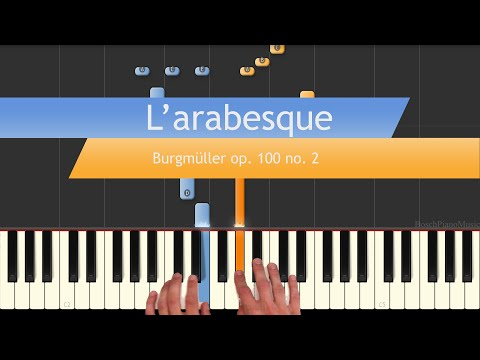

In [5]:
ipd.YouTubeVideo('ZTJ0AYKNdgI')

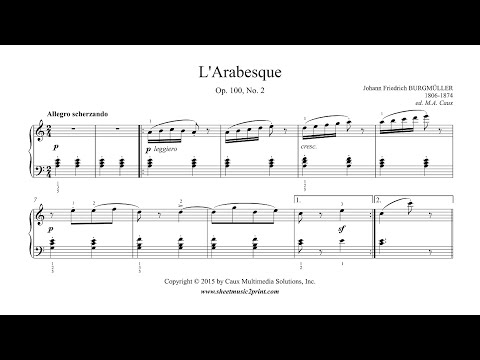

In [6]:
ipd.YouTubeVideo('1oMm_n38OxQ')

Observe como cada versão diferente tem uma duração distinta. Mesmo que expressássemos os dois sinais de áudio usando o mesmo espaço de recursos (por exemplo, espectrogramas), não poderíamos simplesmente usar uma distâncias entre pares simples. Os sinais têm comprimentos diferentes (4 segundos de diferença).

Como visto em sala de aula, o problema de alinhamento de músicas tem diversas aplicações nas bibliotecas digitais musicais. Uma delas, são aplicativos que permitem o chaveamento entre diferentes versões em um mesmo instante de tempo (na mesma nota). Uma outra é a análise de performance.

Para alinhar músicas vamos fazer uso de *Dynamic Time Warping*.

## Dynamic Time Warping

### Do Wikipedia

Dynamic time warping (DTW) é um algoritmo para comparar e alinhar duas séries temporais. A DTW é utilizada para encontrar o alinhamento não-linear ótimo entre duas sequências de valores numéricos. Dessa maneira, é possível encontrar padrões entre medições de eventos com diferentes ritmos. Por exemplo, é possível casar a série temporal obtida por acelerômetros (ou outros sensores) de duas pessoas andando em diferentes velocidades.

DTW pode ser utilizada para alinhar qualquer tipo de dado que obedeça uma ordem temporal, como vídeo, áudio e imagens. Entre as diversas aplicações da DTW, encontra-se o reconhecimento de fala e de assinatura, bem como o alinhamento de gravações musicais com suas respectivas partituras.

**Exemplo**

Para entender o algoritmo, vamos criar duas vetores de tamanhos distintos.

In [7]:
x = np.array([1, 4, 4, 2, -4, -4, 9])
y = np.array([1, 3, 4, 3, 1, -1, -2, -1, 12])
nx = len(x)
ny = len(y)

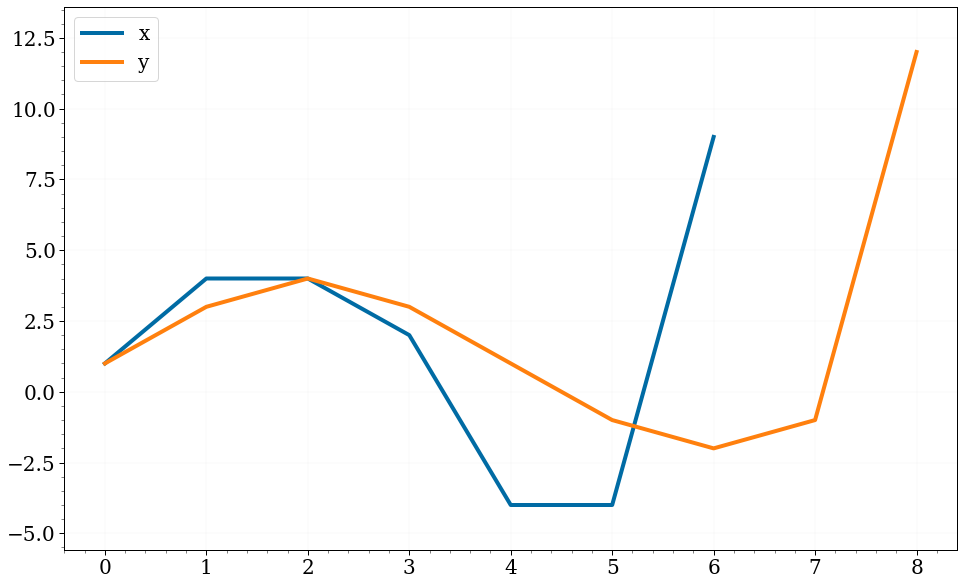

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(x)
ax.plot(y)
ax.legend(('x', 'y'))

Neste exemplo simples, há apenas um valor ou "atributo" em cada índice de tempo. Na prática, você pode usar sequências de vetores, por exemplo, espectrogramas ou cromogramas.

### Distância

O DTW requer o uso de uma métrica de distância entre as observações correspondentes de $x$ e $y$. 

**Euclidiana**

Uma escolha comum é a distância euclidiana.

$$d(\mathbf{f}_1, \mathbf{f}_2) = || \mathbf{f}_1 - \mathbf{f}_2 || = \sqrt{\sum_i (\mathbf{f}_1[i] - \mathbf{f}_2[i])^2}$$

Observe como os vetores aqui tem as mesmas dimensões. Tal dimensão **não é o tempo**, sim o **número de observações por tempo**. No exemplo acima temos apenas uma observação por tempo. Porém, ao fazer o cromagrama de uma música, vide abaixo, teremos 12 observações por tempo.

No exemplo abaixo temos duas observações por tempo.

**Coseno**

Uma outra métrica de distância é o 1-coseno. Quando dois vetores apontam na mesma direção, o coseno entre os mesmos é 1. Quando apontam em direções opostas, o coseno vira 0. Assim, vamo fazer 1-coseno vamos capturar uma noção de distância que não se importa com a magnitude dos valores, sim com a direção dos vetores.

![](./cos.png)

In [9]:
import scipy.spatial as sp
sp.distance.cosine([1, 0], [5, 12])

0.6153846153846154

Observe que magnitudes diferentes apontando na mesma direção

In [10]:
sp.distance.cosine([1, 1], [9, 9])

0.0

### Cromagrama

Como vimos em sala de aula, podemos usar o **cromagrama**, ou **vetor de cromas**, para representar músicas. Um vetor de croma é um vetor de característica de 12 elementos. Cada elemento indica a quantidade de energia em um *semitom* {C, C #, D, D #, E, ..., B}.

Vamos comparar dois vetores de croma da mesma música usando librosa.

Carregando uma música com librosa. Vamos focar nos primeiros 15 segundos da música apenas. Nossa comparação será de duas versões da música [Body and Soul](https://en.wikipedia.org/wiki/Body_and_Soul_(1930_song)). 

**Do Wikipedia**

"Body and Soul" foi escrita para a atriz e cantora inglesa Gertrude Lawrence, sendo interpretada pela primeira vez por ela, ainda na Inglaterra. Libby Holman foi a responsável pelo lançamento da canção nos Estados Unidos. Inicialmente, a música foi proibida de ser executada nas estações de rádio do país, porém a popularidade da canção cresceu muito nas décadas de 1930 e 1940, sendo regravada por uma série de artistas. A primeira regravação de "Body and Soul" foi feita ainda em 1930 pelo cantor estadunidense Louis Armstrong, que após o seu lançamento alcançou o número 12 na parada de singles norte-americana. Até o final da década, a canção havia sido regravada por 11 grupos, senda a mais bem-sucedida nas paradas a versão original da canção lançada por Libby Holman tando atingido o número 3. "Body and Soul" continua a ser um padrão de jazz, com centenas de versões cantadas e gravadas por dezenas de artistas. Clássicas gravações vocais incluem as de: Ella Fitzgerald, Hanshaw Annette, Billie Holiday, Billy Eckstine , Etta James , Sarah Vaughan e Frank Sinatra, e músicos como Benny Goodman, Lee Konitz, John Coltrane, Charles Mingus, Dexter Gordon, Sonny Stitt e Lester Young.

**MP3s**

Na pasta `mp3s` existem diferentes versões de Body and Soul. As mesmas foram identificadas com ajuda da base de dados chamada de [JazzTube](http://mir.audiolabs.uni-erlangen.de/jazztube). O JazzTube contém um série de referências a clássicos do Jazz no YouTube. Caso queira, explore a base pois pode ser uma fonte para projetos futuros.

O professor da disciplina baixou os mp3s do YouTube usando a ferramenta [youtube-dl](https://youtube-dl.org/). Abaixo segue um exemplo de uso da mesma, não precisa executar.

```bash
$ youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=_OFMkCeP6ok
```

*Abaixo uma versão antiga de Chu Berry e Roy Eldridge*

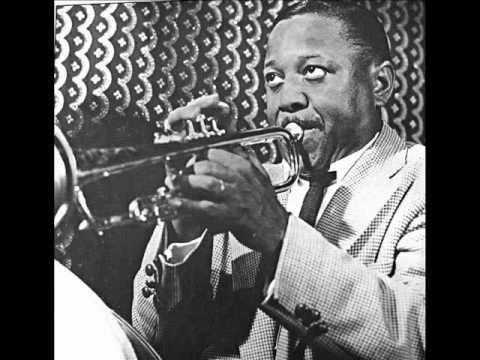

In [11]:
ipd.YouTubeVideo('Lor80WUVbtw')

/home/thiagopoppe/anaconda3/envs/mir/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


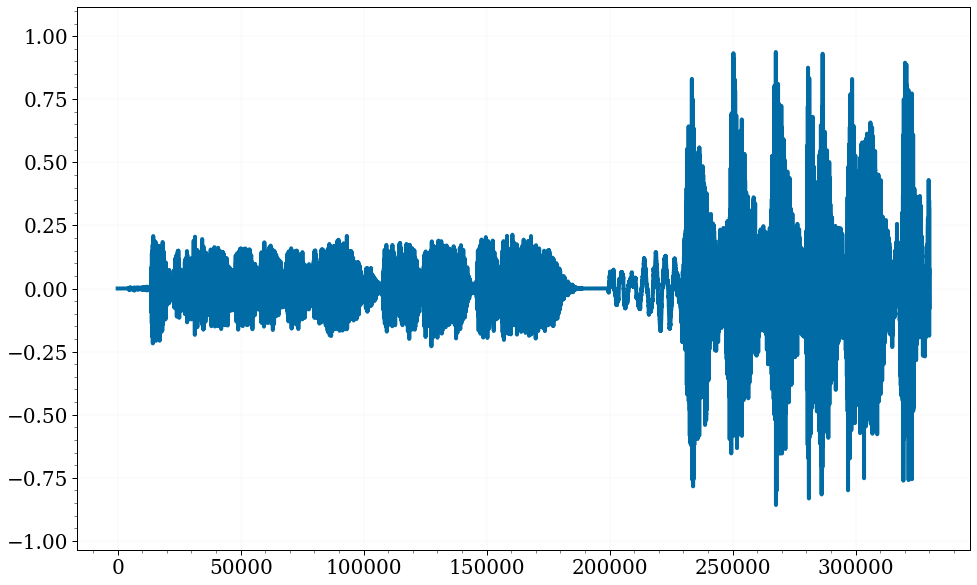

In [12]:
wave_classic, sr = librosa.load('mp3s/Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3',
                                duration=15, sr=22000)
plt.plot(wave_classic)

Vamos computar o cromograma da música com librosa.

In [13]:
chroma_classic = librosa.feature.chroma_stft(wave_classic, sr=sr)
chroma_classic.shape

(12, 645)

Plotar o mesmo.

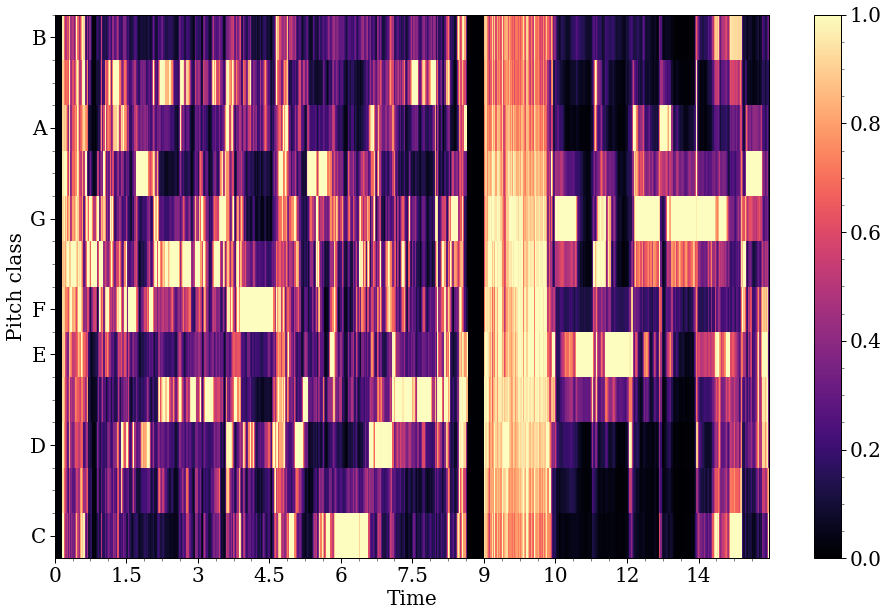

In [14]:
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

*Agora uma versão mais nova de Tony Bennett e Amy Winehouse*

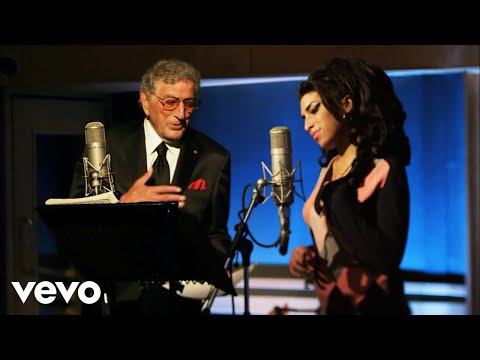

In [15]:
ipd.YouTubeVideo('_OFMkCeP6ok')

Tanto em áudio quanto em cromagrama, as duas versões são bem diferentes.

In [16]:
wave_amy, sr = librosa.load('mp3s/Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3',
                        duration=15)

/home/thiagopoppe/anaconda3/envs/mir/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


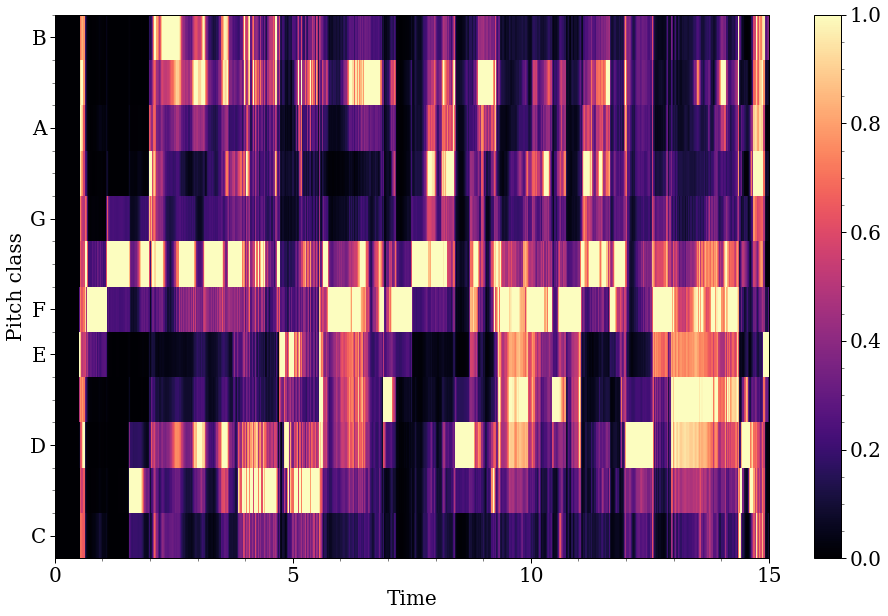

In [17]:
chroma_amy = librosa.feature.chroma_stft(wave_amy, sr=sr)
chroma_amy.shape
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Para comparar as duas com DTW, temos que computar a distância coseno entre as colunas.

In [18]:
print(chroma_classic[:, 0].shape)
print(chroma_amy[:, 0].shape)

(12,)
(12,)


Aqui observamos nosso primeiro problema, a presença de zeros leva a disância para `nan`. Portanto, é mais comum usar versões suavizadas do cromagrama.

In [19]:
sp.distance.cosine(chroma_classic[:, 100], chroma_amy[:, 60])

0.37101107835769653

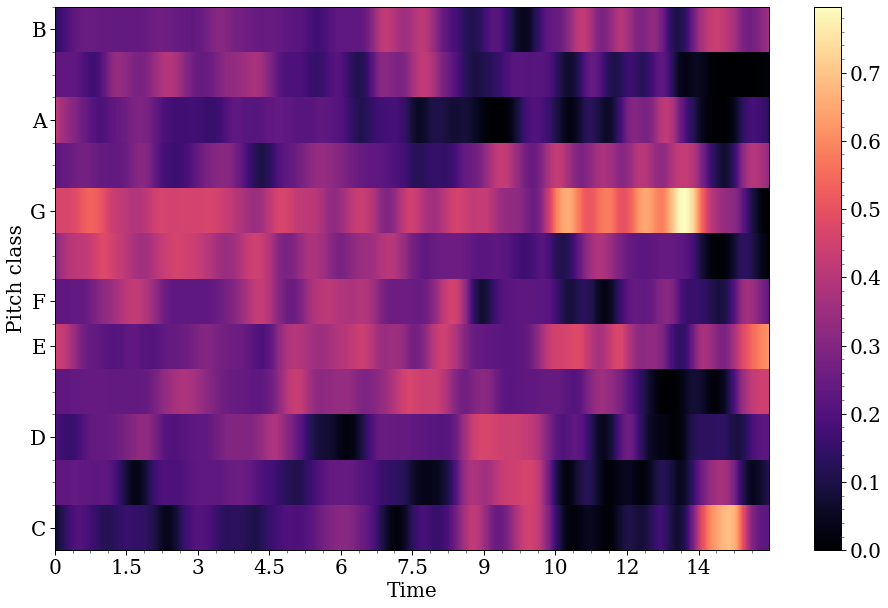

In [20]:
chroma_classic = librosa.feature.chroma_cens(wave_classic, sr=sr)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

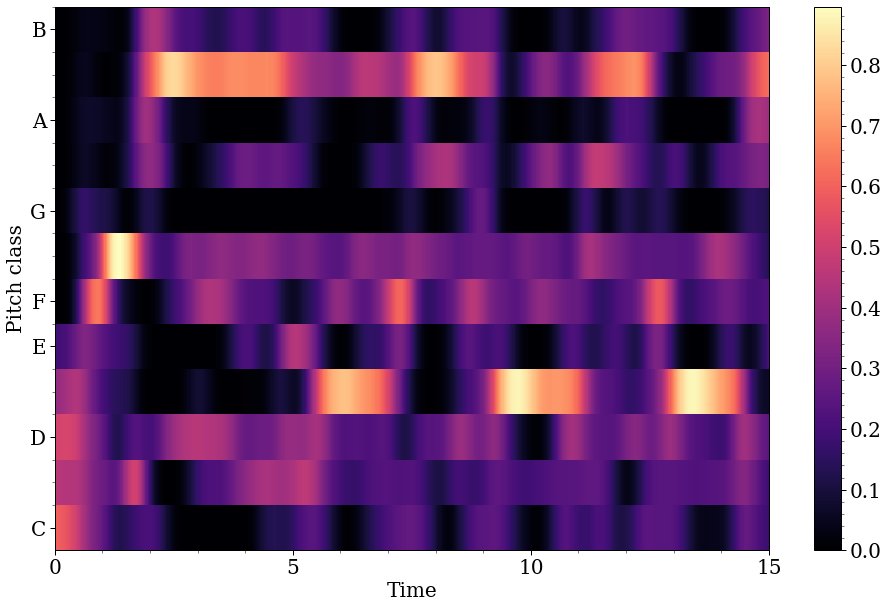

In [21]:
chroma_amy = librosa.feature.chroma_cens(wave_amy, sr=sr)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Qual foi a ideia? Veja os slides das aula.

1. Tirar o log para ficar em uma *escala mais musical*
1. Somar uma pequena constante
1. Normalizar as colunas
1. Dentre outros

In [22]:
sp.distance.cosine(chroma_classic[:, 0], chroma_amy[:, 0])

0.5900771244523135

## Tarefa 1

Agora vamos programar. Sua primeira tarefa é implementar o Dynamic Time Warping. Seu código deve fazer uso de duas funções, uma para computar a matriz de custo. Esta se chama `dtw_table` abaixo. Pode usar a distância euclideana por simplicidade. 

![](https://dcc.ufmg.br/~flaviovdf/mir/lab05/imgs/saida1.png)

**Questão 1**

Seu código deve gerar uma saída como a acima. Caso fique igual, 100%. Observe que a mesma não corresponde as saída do livros, Python indexa de cima para baixo. O livro de baixo para cima. De qualquer forma, isto é apenas um pequeno detalhe que não muda o algoritmo. Caso queira, mude o código para receber uma função de distância.

Seu código abaixo já vai receber matrizes onde as colunas são tempo e as linhas são observações.

In [23]:
import scipy.spatial as sp

def dtw_table(X, Y):
    '''
    Retorna a matriz de DTW entre as músicas.
    
    Argumentos
    ----------
    X: matriz onde as colunas são tempo e as linhas são atributos
    Y: matriz onde as colunas são tempo e as linhas são atributos
    ''' 
    n_x = X.shape[1]
    n_y = Y.shape[1]
    
    D = np.zeros(shape=(n_x, n_y), dtype='d')
    
    # Caso base do algoritmo (linhas e colunas igual à distância das observações)
    D[0, 0] = sp.distance.euclidean(X[:, 0], Y[:, 0])
    for i in range(1, n_x):
        D[i, 0] = D[i-1, 0] + sp.distance.euclidean(X[:, i], Y[:, 0])
    for j in range(1, n_y):
        D[0, j] = D[0, j-1] + sp.distance.euclidean(X[:, 0], Y[:, j])
        
    # Caso recursivo com programação dinâmica implementado de forma bottom-up
    for i in range(1, n_x):
        for j in range(1, n_y):
            D[i, j] = sp.distance.euclidean(X[:, i], Y[:, j]) + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    
    return D

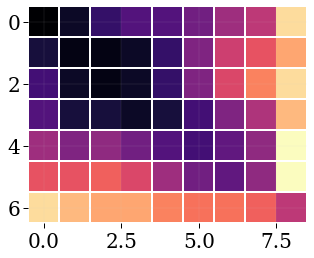

In [24]:
def plot_dtw_table(D, path=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(D, cmap='magma')
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    
    ax.set_xticks(np.arange(D.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(D.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    if path:
        x = []
        y = []
        for n, m in path:
            y.append(n)
            x.append(m)
        ax.plot(x, y, color='r')
    
D = dtw_table(x[None], y[None]) # Não apagar isto é o teste!!!
plot_dtw_table(D)

**Questão 2**

Agora, crie uma função que retorna uma lista de tuplas. Esta lista contém o caminho ótimo do DTW. Para o exemplo acima com distância euclidiana, o caminho é:

```
[(6, 8),
 (5, 7),
 (5, 6),
 (4, 5),
 (3, 4),
 (3, 3),
 (2, 2),
 (1, 2),
 (1, 1),
 (0, 0)]
 ```
 
O plot agora deve ficar estilo a figura abaixo.

![](https://dcc.ufmg.br/~flaviovdf/mir/lab05/imgs/saida2.png)

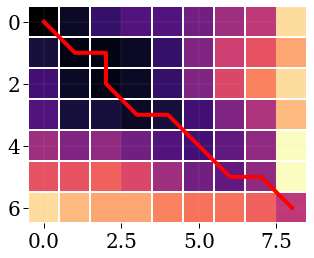

In [25]:
def dtw(X, Y):
    if X.ndim == 1:
        X = X[None]
        Y = Y[None]
        
    D = dtw_table(X, Y)
    
    n_x = X.shape[1]
    n_y = Y.shape[1]
    
    n = n_x - 1
    m = n_y - 1
    path = [(n, m)]
    
    while n > 0 or m > 0:
        if n == 0:
            while m > 0:
                m = m - 1
                path += [(n, m)]
                
        if m == 0:
            while n > 0:
                n = m - 1
                path += [(n, m)]
            
        if D[n - 1, m - 1] < D[n - 1, m] and D[n - 1, m - 1] < D[n, m - 1]:
            n = n - 1
            m = m - 1
        elif D[n - 1, m] < D[n, m - 1]:
            n = n - 1
        else:
            m = m - 1
        path += [(n, m)]
    return D, path

D, path = dtw(x, y)
plot_dtw_table(D, path)

In [26]:
# Mesmo com o código já estar implementado acima, irei fazer o meu só pra aprender :)
def mydtw(D, n_x, n_y):
    n = n_x - 1
    m = n_y - 1
    path = [(n, m)]
    
    while n > 0 and m > 0:
        # Verificando se a diagonal é a menor distância
        if D[n-1, m-1] < D[n-1, m] and D[n-1, m-1] < D[n, m-1]:
            path.append((n-1,m-1))
            n -= 1
            m -= 1
            
        # Senão devemos verificar qual das outras duas distâncias é a menor
        elif D[n-1, m] < D[n, m-1]:
            path.append((n-1, m))
            n -= 1
        else:
            path.append((n, m-1))
            m -= 1
        
    # Apenas para cobrir o caso onde caminhamos tudo em 'm' e ainda "sobra" em 'n'
    while n > 0:
        path.append((n-1, 0))
        n -= 1
        
    # Caso análogo ao de cima
    while m > 0:
        path.append((0, m-1))
        m -= 1
        
    return path

D = dtw_table(x[None], y[None])
mypath = mydtw(D, x.shape[0], y.shape[0])
mypath

[(6, 8),
 (5, 7),
 (5, 6),
 (4, 5),
 (3, 4),
 (3, 3),
 (2, 2),
 (1, 2),
 (1, 1),
 (0, 0)]

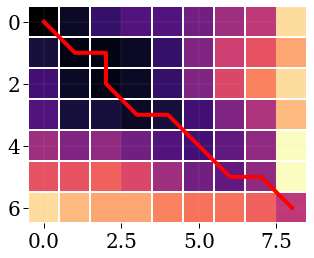

In [27]:
plot_dtw_table(D, mypath)

## Tarefa 2

Usando a biblioteca [FastDTW](https://github.com/slaypni/fastdtw) ordena as versões das músicas que são mais e menos similares com a versão de Tony Bennet e Amy Winehouse

```bash
$ pip install fastdtw
```

A biblioteca FastDTW é interessante pois é toda linear em tempo e memória. Assim, podemos computar a distância entre versões inteiras de músicas. Faça isso. Caso não execute, trunque em 2mins. Caso não execute, trunque em 1 min.

Abaixo executo a FastDTW com os 15 segundos que carregamos antes. Observe como passo a transposta, pois a biblioteca funciona em linhas, não em colunas, como o livro.

In [28]:
from fastdtw import fastdtw

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(chroma_amy.T, chroma_classic.T, dist=sp.distance.cosine)

In [29]:
distance

216.95943246341628

In [30]:
path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 32),
 (33, 33),
 (34, 34),
 (35, 35),
 (36, 36),
 (37, 37),
 (38, 38),
 (39, 39),
 (40, 40),
 (41, 41),
 (42, 42),
 (43, 43),
 (44, 44),
 (45, 44),
 (46, 44),
 (47, 44),
 (48, 44),
 (49, 44),
 (50, 44),
 (51, 44),
 (52, 44),
 (53, 44),
 (54, 44),
 (55, 44),
 (56, 44),
 (57, 44),
 (58, 44),
 (59, 44),
 (60, 44),
 (61, 44),
 (62, 44),
 (63, 44),
 (64, 44),
 (65, 44),
 (66, 45),
 (67, 45),
 (68, 46),
 (69, 47),
 (70, 48),
 (71, 49),
 (72, 50),
 (73, 51),
 (74, 52),
 (75, 53),
 (76, 54),
 (77, 55),
 (78, 56),
 (79, 57),
 (80, 58),
 (81, 59),
 (82, 60),
 (83, 61),
 (84, 62),
 (85, 63),
 (86, 64),
 (87, 65),
 (88, 66),
 (89, 67),
 (90, 68),
 (91, 69),
 (92, 70

**Questão 1**

Ordene as músicas por similaridade com a versão mais recent (Bennet e Winehouse). Indique sua resposta abaixo.

> Sua respota. Ou seja, os ids do YouTube aqui do mais até o menos similar. Escute as músicas, você percebe a similaridade? Em quais aspectos?

- **Algumas notas importantes:**
    1. Preferi trabalhar com os arquivos que foram baixados na pasta `mp3s`.
    2. Preferi trabalhar com os cromagramas normalizados como foi apresentado antes no notebook, ajudando também no tempo de execução dessa etapa.
    3. Por algum motivo estava dando um erro chatinho de ``Tuple index out of range`` ao utilizar a distância de cosseno, logo optei por usar a distância euclidiana que executou sem nenhum problema.

In [31]:
import warnings
from glob import glob
from tqdm.notebook import tqdm

# apenas para não vermos um warning do librosa sempre que a gente carrega um .mp3
warnings.filterwarnings('ignore')

In [32]:
files = glob('./mp3s/*.mp3')
amy_file = list(filter(lambda name: 'Amy' in name, files))[0]

music_amy, sr = librosa.load(amy_file)
chroma_amy = librosa.feature.chroma_cens(music_amy, sr=sr)

In [33]:
similarities = []
for file in tqdm(files):
    if file == amy_file:
        continue

    music_other, sr = librosa.load(file)
    chroma_other = librosa.feature.chroma_cens(music_other, sr=sr)
    dist, path = fastdtw(chroma_amy.T, chroma_other.T, dist=sp.distance.euclidean)

    similarities.append({
        'name': file,
        'dist': dist,
        'path': path,
        'chromagram': chroma_other
    })

similarities = sorted(similarities, key=lambda s: s['dist'])

  0%|          | 0/15 [00:00<?, ?it/s]

In [34]:
print('Lista de músicas em ordem de similaridade')
for idx, sim in enumerate(similarities):
    print('{}. {:.2f} => {}'.format(idx+1, sim['dist'], sim['name']))

Lista de músicas em ordem de similaridade
1. 5923.68 => ./mp3s/Sonny Stitt _ Body and Soul (1948)-H_IZdoQaoj0.mp3
2. 5941.71 => ./mp3s/Stan Getz Quintet - Body and Soul-3dgwQSrIWKs.mp3
3. 5993.43 => ./mp3s/Stan Getz - Body and Soul-J5hZUnDhlhg.mp3
4. 5997.34 => ./mp3s/Stan Getz - Body and Soul-qPJpP2mxbsg.mp3
5. 6054.62 => ./mp3s/Stan Getz Quintet - Body And Soul (Norgran Records 1952)-C2QwjXQMIZE.mp3
6. 6420.93 => ./mp3s/Body and soul Don Byas-402zBdIdmNU.mp3
7. 6644.18 => ./mp3s/Coleman Hawkins-Body and Soul 1939.wmv-Sul_9BcgOOI.mp3
8. 7486.09 => ./mp3s/Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3
9. 7658.58 => ./mp3s/Chuck Berry _ Roy Eldridge- Body and Soul-0i5jQAAL60Y.mp3
10. 9117.69 => ./mp3s/JOHN COLTRANE - BODY AND SOUL-jUUNYtSkseI.mp3
11. 9283.85 => ./mp3s/John Coltrane Quartet - Body And Soul-62FQT9PXWM4.mp3
12. 9533.32 => ./mp3s/John Coltrane _Body And Soul_-8z-dDWrIKDQ.mp3
13. 11216.86 => ./mp3s/♪ Body and Soul (Alternate take) _ John Coltrane-q4XdeSN4rCI.mp3
14

- **Resposta:** Ao ouvirmos a última música da lista acima podemos perceber que ela começa de maneira similar porém mais lenta que a versão de Bennet e Winehouse, porém, o que mais me chamou a atenção foi que essa música possui quase o dobro de duração se compararmos com a música de referência, onde o meio dela é marcado por (pelo que eu acho) um solo de saxofone estentido que não está presente (com essa duração) na música de referência, fazendo com que elas não sejam tão similares. Ao ouvirmos as 4 primeiras colocadas da lista podemos perceber que de fato todas são "igualmente" similares quando comparamos com a música referência, justificando os valores relativamente próximos uns dos outro, além de perceber mais e mais diferenças a medida que ouvimos as músicas nessa ordem.

**Questão 2**

Plote o caminho de sincronização da música mais e menos similar. Isto é, no eixo-x você pode usar o tempo da música referência (Bennet e Winehouse). No eixo-y, o tempo das outras músicas. 

> Qual interpretação você tira do plot?

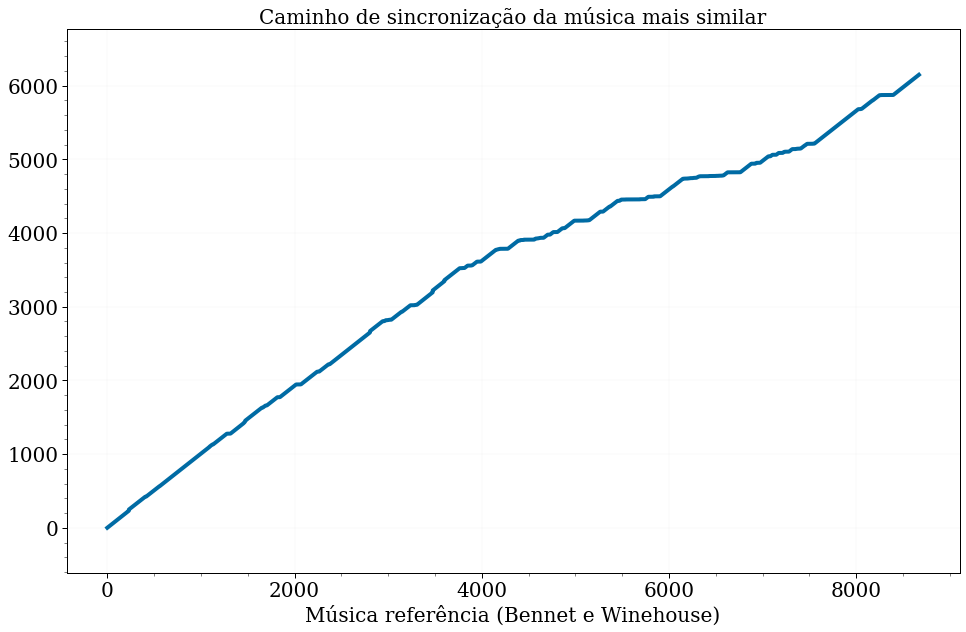

In [35]:
plt.title('Caminho de sincronização da música mais similar')
plt.plot([x for x,y in similarities[0]['path']], [y for x,y in similarities[0]['path']])
plt.xlabel('Música referência (Bennet e Winehouse)')
plt.show()

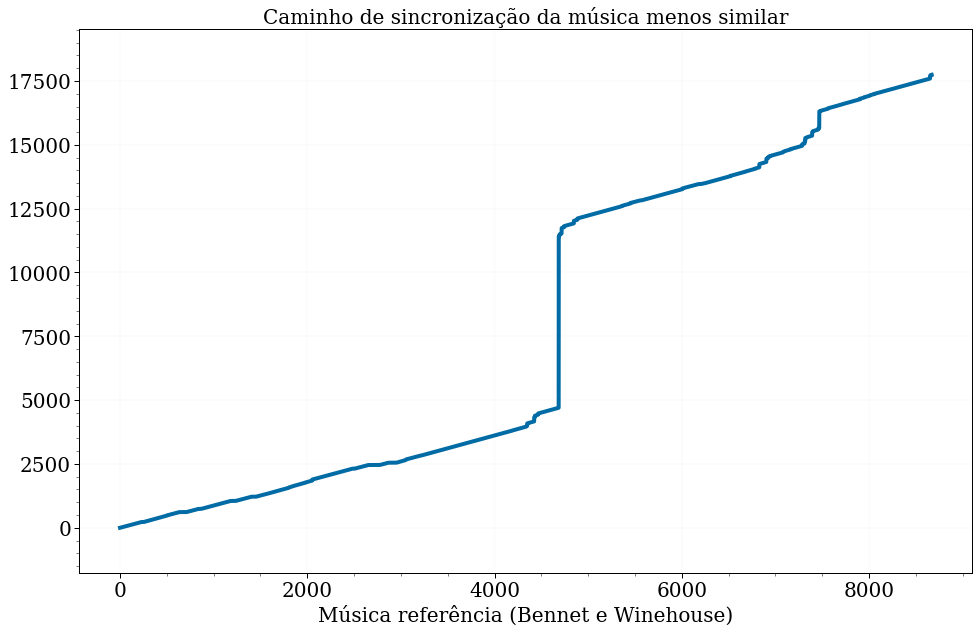

In [36]:
plt.title('Caminho de sincronização da música menos similar')
plt.plot([x for x,y in similarities[-1]['path']], [y for x,y in similarities[-1]['path']])
plt.xlabel('Música referência (Bennet e Winehouse)')
plt.show()

- **Resposta:** De fato pelo primeiro plot temos que essa versão é mais similar com a música de referência uma vez que temos quase que um caminho diagonal ao longo da matriz do DTW. O caminho feito pela outra música traz uma linha reta bem no meio da matriz que deve ser justamente aquele solo que foi comentado, marcando o prolongamento dessa versão.

**Questão 3**

Plote os cromagramas da músicas mais e menos similar. Compare com a versão base.

> Qual interpretação você tira do plot?

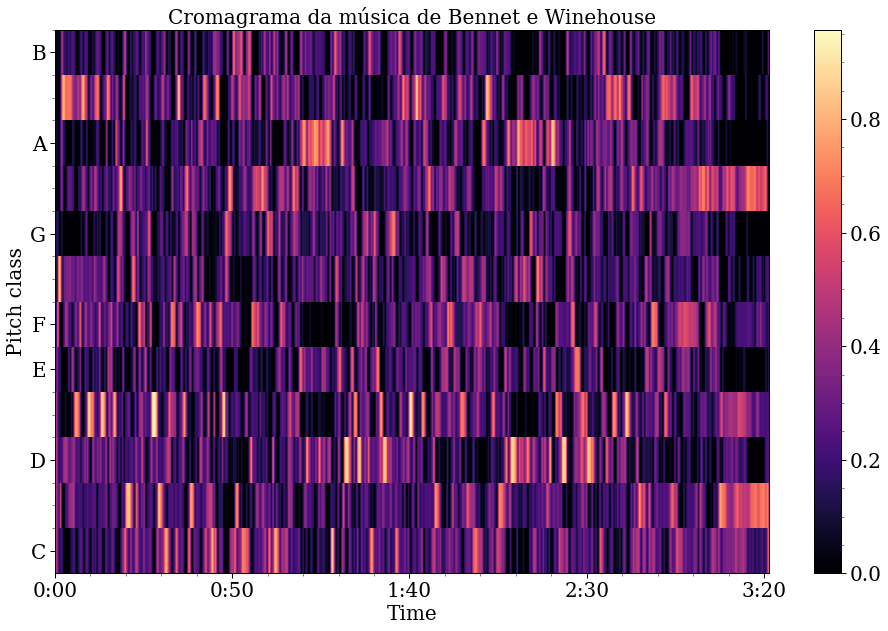

In [37]:
fig, ax = plt.subplots(1, 1)
plt.title('Cromagrama da música de Bennet e Winehouse')
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)
plt.show()

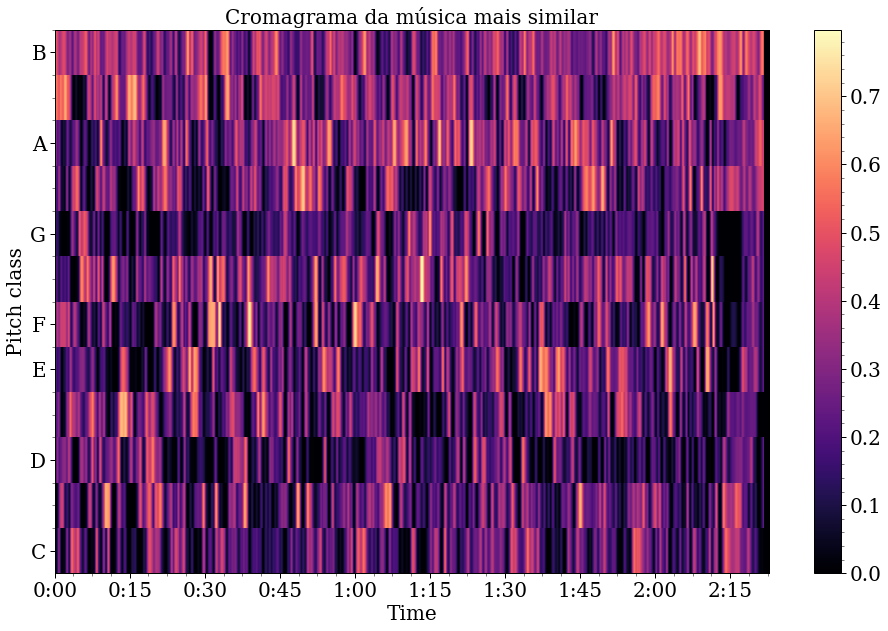

In [38]:
fig, ax = plt.subplots(1, 1)
plt.title('Cromagrama da música mais similar')
img = librosa.display.specshow(similarities[0]['chromagram'],
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)
plt.show()

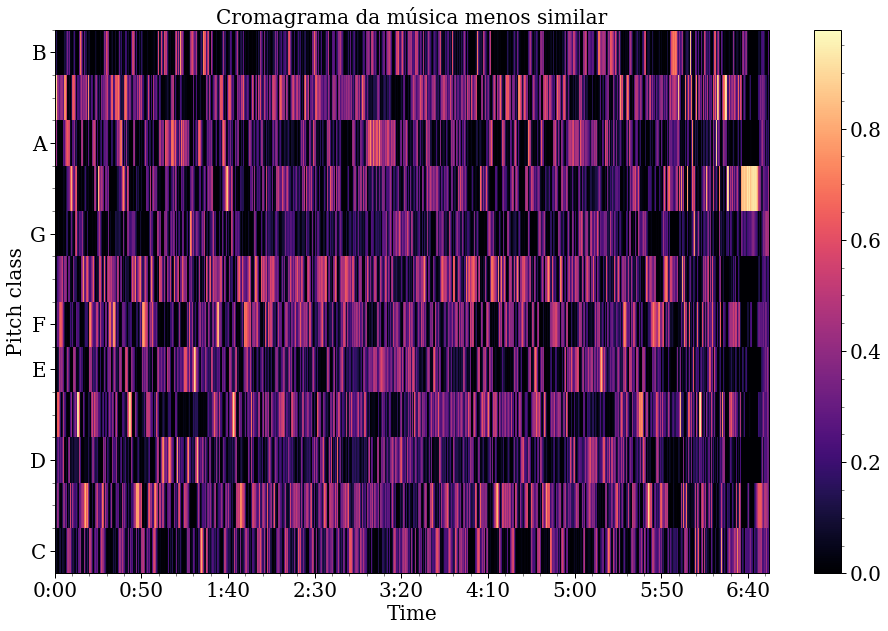

In [39]:
fig, ax = plt.subplots(1, 1)
plt.title('Cromagrama da música menos similar')
img = librosa.display.specshow(similarities[-1]['chromagram'],
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)
plt.show()

- **Resposta:** observar os cromagramas traz uma análise interessante onde podemos ver algumas "seções" na música que aparentemente se repetem nos três mas com algumas intensidades e tempos diferentes, e é isso que talvez torna uma versão mais similar do que outra. Podemos também perceber, pelo menos dá a impressão, de que o cromagrama da versão menos similar possui as pausas e algumas seções mais pro final que são mais similares com a música de referência. Também podemos observar esse fato no plot do seu caminho, onde temos quase que a volta de um caminho em diagonal no final do plot.